Import packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset, DataLoader
from sksurv.metrics import integrated_brier_score
from sksurv.util import Surv

import nnet_survival_pytorch

load in dataset

In [4]:
df_train = pd.read_csv('our_data/imputed_train_nocat.csv')
df_train = df_train.drop(['X', 'PO_7', "PO_30", 'PO_60', 'PO_180', 'PO_365', "PO_730", 'PO_1460', 'subject_id'], axis = 1)

df_test = pd.read_csv('our_data/imputed_test_nocat.csv')
df_test = df_test.drop(['X', 'PO_7', "PO_30", 'PO_60', 'PO_180', 'PO_365', "PO_730", 'PO_1460', 'subject_id'], axis = 1)

breaks = np.array([0., 7., 30., 60., 180., 365., 730., 1460.])
n_intervals=len(breaks)-1

# print(breaks)
# print(df_train.head())
# print(df_train.columns)


X_train = df_train.drop(['survival_days', 'event'], axis = 1).to_numpy()
surtim_train = df_train['survival_days'].to_numpy()
surind_train = df_train['event'].to_numpy().astype(bool)


n_predictors = X_train.shape[1]

X_test = df_test.drop(['survival_days', 'event'], axis = 1).to_numpy()
surtim_test = df_test['survival_days'].to_numpy()
surind_test = df_test['event'].to_numpy().astype(bool)

# print(X_train)
# print(surtim_train)
# print(surind_train)

load y_train and y_test using survnet functions

In [6]:
y_train = nnet_survival_pytorch.make_surv_array(surtim_train, surind_train, breaks)

y_test = nnet_survival_pytorch.make_surv_array(surtim_test, surind_test, breaks)

print(breaks)
# with np.printoptions(threshold=np.inf):
#     print(y_train)
# print(y_test)

[   0.    7.   30.   60.  180.  365.  730. 1460.]


making dataset and dataloader

In [8]:
class MyDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        myItem = self.data[idx]
        myLabel = self.labels[idx]
        if self.transform:
            myItem = self.transform(myItem)
        myItem = torch.from_numpy(myItem).float()
        myLabel = torch.from_numpy(myLabel).float()
        return myItem, myLabel


batch_size = 4
train_dataset = MyDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MyDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [10]:
device = ( #disabled mps because max_unpool2d not implemented yet
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [12]:
times = np.append(breaks[1:-1], np.max(surtim_train) - 1)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss = 0.0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        if torch.isnan(X).any():
            print("NaN detected in inputs")
        if torch.isinf(X).any():
            print("Inf detected in inputs")
        if torch.isnan(y).any():
            print("NaN detected in targets")
        if torch.isinf(y).any():
            print("Inf detected in targets")
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_loss += loss.item()

    avg_train_loss = train_loss / size  # average loss for epoch

    y_pred=model(torch.tensor(X_train).float().to(device)).squeeze().detach().cpu().numpy()
    y_true = Surv.from_arrays(event=surind_train, time=surtim_train)
    ibs = integrated_brier_score(y_true, y_true, y_pred, times)

    return avg_train_loss, ibs
        # if batch % 10 == 0:
        #     loss, current = loss.item(), (batch + 1) * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    # test_loss, correct = 0, 0
    test_loss=0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            print(y)
            pred = model(X)
            print(pred)
            test_loss += loss_fn(pred, y).item()
            # correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    # correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

In [57]:
class SimpleSurvivalModel(nn.Module):
    def __init__(self, n_predictors, n_intervals):
        super(SimpleSurvivalModel, self).__init__()
        self.lin = nn.Linear(n_predictors, 8)
        self.lin2 = nn.Linear(8, n_intervals)

    def forward(self, x):
        x = F.gelu(self.lin(x))
        x = F.sigmoid(self.lin2(x))  # Use torch.sigmoid instead of F.sigmoid (deprecated)
        return x



In [59]:
learning_rate = 0.001
model = SimpleSurvivalModel(n_predictors=n_predictors, n_intervals=n_intervals).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
my_loss = nnet_survival_pytorch.surv_likelihood(n_intervals)

epochs = 50
training_loss = []
ibs_epoch = []
for epoch in range(epochs):
    if epoch % 5 == 0:
        print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss, ibs = train(train_dataloader, model, my_loss, optimizer)
    training_loss.append(train_loss)
    ibs_epoch.append(ibs)


# test(test_dataloader, model, my_loss)

Epoch 1
-------------------------------
Epoch 6
-------------------------------
Epoch 11
-------------------------------
Epoch 16
-------------------------------
Epoch 21
-------------------------------
Epoch 26
-------------------------------
Epoch 31
-------------------------------
Epoch 36
-------------------------------
Epoch 41
-------------------------------
Epoch 46
-------------------------------


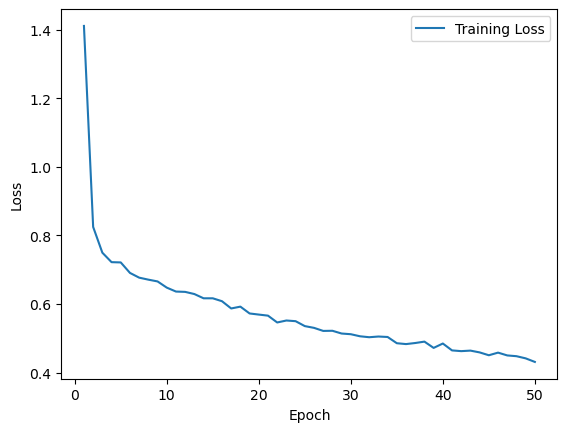

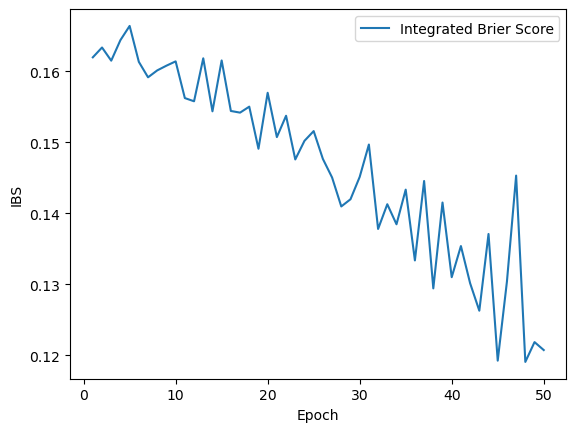

In [61]:
epochs = range(1, 50 + 1)
plt.plot(epochs, training_loss, label='Training Loss')
# plt.plot(epochs, validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, ibs_epoch, label='Integrated Brier Score')
# plt.plot(epochs, validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('IBS')
plt.legend()
plt.show()

(454, 7)


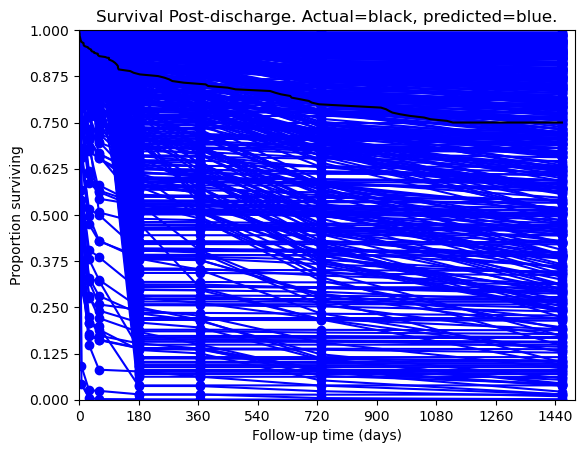

In [63]:
y_pred=model(torch.tensor(X_train).float().to(device)).squeeze().detach().cpu().numpy()


print(y_pred.shape)
kmf = KaplanMeierFitter()
kmf.fit(surtim_train, event_observed=surind_train)
for i in range(y_pred.shape[0]):
    plt.plot(breaks,np.concatenate(([1],np.cumprod(y_pred[i,:]))),'bo-')
plt.plot(kmf.survival_function_.index.values, kmf.survival_function_.KM_estimate,color='k')
plt.xticks(np.arange(0, 1500, 180))
plt.yticks(np.arange(0, 1.0001, 0.125))
plt.xlim([0,1500])
plt.ylim([0,1])
plt.xlabel('Follow-up time (days)')
plt.ylabel('Proportion surviving')
plt.title('Survival Post-discharge. Actual=black, predicted=blue.')
plt.show()

predicting probability of survival of patient in row 4 at 30 days

In [65]:
pred_surv = nnet_survival_pytorch.nnet_pred_surv(y_pred, breaks, 30)
print(pred_surv[4])

0.9926112294197083


calculating c-index at a specific time

In [67]:
y_pred_test = model(torch.tensor(X_test).float().to(device)).squeeze().detach().cpu().numpy()

# print(y_pred_test)

# print(breaks)
# print(y_pred_test.shape)


result = np.apply_along_axis(np.minimum.accumulate, axis=0, arr=y_pred_test)

# print(result.shape)

for i in range(y_pred_test.shape[1]):
    s_pred = result[:, i]

    c_index = concordance_index(surtim_test, -s_pred, surind_test)
    print(f'C-index (interval {i})', c_index)

C-index (interval 0) 0.5816425120772947
C-index (interval 1) 0.5383252818035427
C-index (interval 2) 0.5371443907675791
C-index (interval 3) 0.566935050993022
C-index (interval 4) 0.539345142243693
C-index (interval 5) 0.5712828770799785
C-index (interval 6) 0.5399355877616747


calculating Integrated brier score

In [69]:
times = np.append(breaks[1:-1], np.max(surtim_test) - 1)

print(times)

y_true = Surv.from_arrays(event=surind_test, time=surtim_test)
ibs = integrated_brier_score(y_true, y_true, y_pred_test, times)

print("Integrated Brier Score (IBS):", ibs)


[   7.   30.   60.  180.  365.  730. 1459.]
Integrated Brier Score (IBS): 0.1552326243460834


attempt at calibration plot

In [37]:

def calibration_plot(time, event, pred_surv_probs, n_bins=10):
    """
    Parameters:
    - time: array-like of observed survival times
    - event: array-like of event indicators (1=event, 0=censored)
    - pred_surv_probs: predicted survival probabilities at eval_time
    - eval_time: time point to evaluate calibration
    - n_bins: number of bins to group predictions
    
    """
    df = pd.DataFrame({
        'time': time,
        'event': event,
        'pred': pred_surv_probs
    })
    
    # Bin data by predicted survival probability
    df['bin'] = pd.qcut(df['pred'], q=n_bins, duplicates='drop')
    
    obs_surv = []
    mean_pred = []
    
    kmf = KaplanMeierFitter()
    
    for bin_range, group in df.groupby('bin'):
        mean_pred.append(group['pred'].mean())
        
        kmf.fit(group['time'], group['event'])
        surv_prob = kmf.survival_function_.iloc[-1].values[0]
        
        obs_surv.append(surv_prob)

    return mean_pred, obs_surv
   


C:\Users\diete\AppData\Local\Temp\ipykernel_16660\333700669.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bin_range, group in df.groupby('bin'):
C:\Users\diete\AppData\Local\Temp\ipykernel_16660\333700669.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for bin_range, group in df.groupby('bin'):
C:\Users\diete\AppData\Local\Temp\ipykernel_16660\333700669.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
 

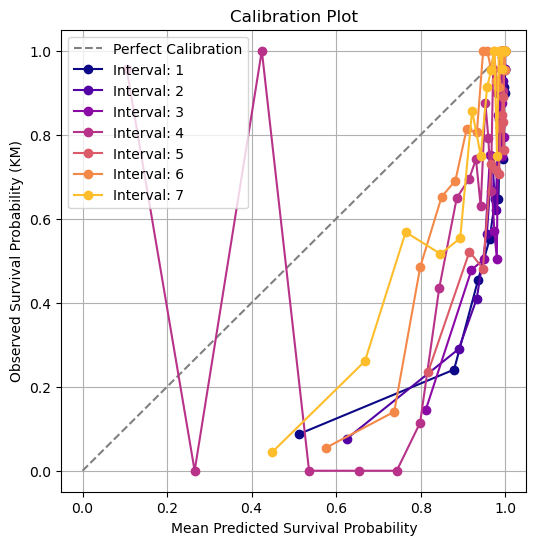

In [71]:
cmap = plt.get_cmap('plasma') 

plt.figure(figsize=(6,6))
plt.plot([0,1], [0,1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Mean Predicted Survival Probability')
plt.ylabel('Observed Survival Probability (KM)')


for i in range(len(breaks) - 1):
    color = cmap(i / (len(breaks) - 1))
    mean_pred, obs_surv = calibration_plot(surtim_train, surind_train.astype(int), y_pred[:,i], n_bins = 20)
    plt.plot(mean_pred, obs_surv, marker='o', linestyle='-', label=f'Interval: {i+1}', color = color)

plt.title(f'Calibration Plot')
plt.legend()
plt.grid(True)
plt.show()